This notebook computes the average SNR a given Voice Dataset. If the SNR is too low, that might reduce the performance or prevent model to learn.

To use this notebook, you need:
- WADA SNR estimation: http://www.cs.cmu.edu/~robust/archive/algorithms/WADA_SNR_IS_2008/
    1. extract in the same folder as this notebook
    2. under MacOS you'll have to rebuild the executable. In the build folder: 1) remove existing .o files and 2) run make


- FFMPEG: ```sudo apt-get install ffmpeg ```     


In [1]:
import os, sys
import glob
import subprocess
import tempfile
import IPython
import soundfile as sf
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
from matplotlib import pylab as plt
%matplotlib inline

In [2]:
# Set the meta parameters
DATA_PATH = "/home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/"
NUM_PROC = 2
CURRENT_PATH = os.getcwd()

In [3]:
CURRENT_PATH

'/home/iref/PycharmProjects/tts-vc/notebooks/dataset_analysis'

In [20]:
def compute_file_snr(file_path):
    """ Convert given file to required format with FFMPEG and process with WADA."""
    _, sr = sf.read(file_path)
    new_file = file_path.replace(".wav", "_tmp.wav")
    if sr != 16000:
        command = f'ffmpeg -i "{file_path}" -ac 1 -acodec pcm_s16le -y -ar 16000 "{new_file}"'
    else:
        command = f'cp "{file_path}" "{new_file}"'
    os.system(command)
    command = [f'"{CURRENT_PATH}/WadaSNR/Exe/WADASNR"', f'-i "{new_file}"', f'-t "{CURRENT_PATH}/WadaSNR/Exe/Alpha0.400000.txt"', '-ifmt mswav']
    try:
        output = subprocess.check_output(" ".join(command), shell=True)
    except:
         return 
    try:
        output = float(output.split()[-3].decode("utf-8"))
    except:
        raise RuntimeError(" ".join(command))
    os.system(f'rm "{new_file}"')
    return output, file_path


In [5]:
wav_file = "/home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/Ranevskaya_F/Ranevskaya_F-07.wav"
output = compute_file_snr(wav_file)

In [6]:
output

(32.0,
 '/home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/Ranevskaya_F/Ranevskaya_F-07.wav')

In [21]:
wav_files = glob.glob(f"{DATA_PATH}/**/*.wav", recursive=True)
print(f" > Number of wav files {len(wav_files)}")

 > Number of wav files 25461


In [18]:
wav_files[11840]

'/home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/urp/ru_0235.wav'

In [22]:
if NUM_PROC == 1:
    file_snrs = [None] * len(wav_files) 
    for idx, wav_file in tqdm(enumerate(wav_files)):
        tup = compute_file_snr(wav_file)
        file_snrs[idx] = tup
else:
    with Pool(NUM_PROC) as pool:
        file_snrs = list(tqdm(pool.imap(compute_file_snr, wav_files), total=len(wav_files)))

100%|██████████| 25461/25461 [05:27<00:00, 77.73it/s]


In [36]:
file_snrs = [e for e in file_snrs if e]

In [37]:
snrs = [tup[0] for tup in file_snrs]

error_idxs = np.where(np.isnan(snrs) == True)[0]
error_files = [file_names[idx] for idx in error_idxs]

file_snrs = [i for j, i in enumerate(file_snrs) if j not in error_idxs]
file_names = [tup[1] for tup in file_snrs]
snrs = [tup[0] for tup in file_snrs]
file_idxs = np.argsort(snrs)


print(f" > Average SNR of the dataset:{np.mean(snrs)}")

 > Average SNR of the dataset:73.8792733264833


In [38]:
def output_snr_with_audio(idx):
    file_idx = file_idxs[idx]
    file_name = file_names[file_idx]
    wav, sr = sf.read(file_name)
    # multi channel to single channel
    if len(wav.shape) == 2:
        wav = wav[:, 0]
    print(f" > {file_name} - snr:{snrs[file_idx]}")
    IPython.display.display(IPython.display.Audio(wav, rate=sr))

In [39]:
# find worse SNR files
N = 10  # number of files to fetch
for i in range(N):
    output_snr_with_audio(i)

 > /home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/user15/common_voice_ru_18898096.wav - snr:-20.0


 > /home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/user15/common_voice_ru_18898099.wav - snr:-20.0


 > /home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/user15/common_voice_ru_18898094.wav - snr:-4.054353


 > /home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/user15/common_voice_ru_18898095.wav - snr:1.524649


 > /home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/user15/common_voice_ru_18898101.wav - snr:3.0


 > /home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/user15/common_voice_ru_18898092.wav - snr:4.0


 > /home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/user15/common_voice_ru_18898121.wav - snr:4.859218


 > /home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/Time_Elizaveta/Time_Elizaveta-05.wav - snr:5.0


 > /home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/user15/common_voice_ru_18898117.wav - snr:5.0


 > /home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/user15/common_voice_ru_18898100.wav - snr:5.0


In [40]:
# find best recordings
N = 10  # number of files to fetch
for i in range(N):
    output_snr_with_audio(-i-1)

 > /home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/user1/common_voice_ru_18919902.wav - snr:100.0


 > /home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/user1/common_voice_ru_18914108.wav - snr:100.0


 > /home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/user1/common_voice_ru_18919804.wav - snr:100.0


 > /home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/user1/common_voice_ru_18929770.wav - snr:100.0


 > /home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/user1/common_voice_ru_18922084.wav - snr:100.0


 > /home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/user1/common_voice_ru_18912860.wav - snr:100.0


 > /home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/user1/common_voice_ru_18929959.wav - snr:100.0


 > /home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/user1/common_voice_ru_18919621.wav - snr:100.0


 > /home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/user1/common_voice_ru_18929094.wav - snr:100.0


 > /home/iref/PycharmProjects/tts-vc/data/speaker_encoder_data/user1/common_voice_ru_18923188.wav - snr:100.0


(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        5.0000e+00, 1.0000e+00, 6.0000e+00, 7.0000e+00, 1.0000e+01,
        4.4000e+01, 3.9000e+01, 4.2000e+01, 8.3000e+01, 9.4000e+01,
        2.5900e+02, 1.7600e+02, 2.0700e+02, 2.3700e+02, 2.7500e+02,
        4.9400e+02, 3.2200e+02, 2.9900e+02, 3.0700e+02, 2.9200e+02,
        5.2700e+02, 2.9400e+02, 2.8200e+02, 3.0500e+02, 2.8800e+02,
        4.7800e+02, 2.6600e+02, 2.7400e+02, 2.5200e+02, 2.1900e+02,
        3.7400e+02, 2.0800e+02, 2.0800e+02, 2.5300e+02, 1.8800e+02,
        3.1400e+02, 1.4100e+02, 1.5700e+02, 1.4400e+02, 1.2800e+02,
        2.1300e+02, 1.4000e+02, 1.2800e+02, 1.1400e+02, 1.1100e+02,
        1.8300e+02, 1.0000e+02, 8.7000e+01, 6.6000e+01, 7.4000e+01,
        1.3700e+02, 6.9000e+01, 6.5000e+01, 5.60

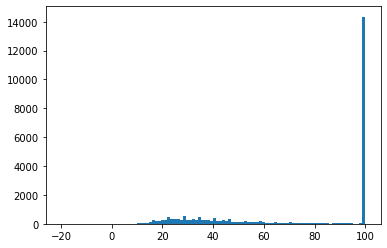

In [41]:
plt.hist(snrs, bins=100)